# Uplink AoA (UL-AoA) based Localization of the Indoor Factory UEs using millimeter 5G Networks

This tutorial estimates the position of based uplink angle of arrival measurements. Uplink Angle of Arrival (AoA) based positioning is a technique used in 5G networks to determine the location of user equipment (UE) by analyzing the angles from which uplink signals are received at the base station (gNodeB). This technique leverages the ability of the gNodeB to estimate the angles of arrival of uplink signals from multiple antennas, enabling the calculation of the UE's position relative to the gNodeB. The details of the procedure are provided below:

- Uplink Signal Reception: When a UE transmits SRS to the gNodeB, the uplink signals are received by multiple antennas at the gNodeB. Each antenna captures the signal from a different angle, allowing the gNodeB to estimate the angles from which the signals arrive.

- Angle Estimation: The gNodeB uses signal processing techniques to estimate the angles of arrival of the uplink signals. This involves analyzing the phase differences and amplitudes of the signals received by different antennas to determine the angles from which the signals originated using ESPRIT or other similar methods.

- Angle of Arrival Calculation: Based on the estimated angles of arrival from multiple antennas, the gNodeB calculates the position of the UE relative to the gNodeB. This calculation typically involves triangulation or multilateration techniques, where the intersection of the estimated angles of arrival is used to determine the UE's position.

- Positioning Accuracy: The accuracy of Uplink AoA based positioning depends on factors such as the number and spacing of antennas at the gNodeB, the signal-to-noise ratio (SNR) of the received signals, and the propagation environment. Higher antenna resolution and better signal quality result in more accurate positioning estimates.

- Applications: Uplink AoA based positioning has various applications in 5G networks, including location-based services, asset tracking, and indoor navigation. By accurately determining the position of UEs, it enables the delivery of location-aware services and improves network management and optimization.


***Positioning Procedure***

- Generate the Reference Signal
- Transmit the Reference Signal
- Pass the Transmit Signal through Wireless Channel
- Add Noise at the Receiver
- Estimate the Channel at Pilot Locations
- Interpolate the channel at remaining locations
- Estimate the angles (Angle of arrival using the channel Estimates)
- Select the most accurate measurements for Positioning.
- Estimate position of the UEs based on AoA measurements.

The simulation considers the following parameters for evaluation of positioning performance:


|Parameters|Values|
| :- | -:  |
| Positioning Method  | UL-AoA based  |
| Parameter Estimation Method  | ESPRIT  |
| Optimization Method | Least Squares |
| Carrier Frequency | 28 GHz |
| Bandwidth | 150 MHz |
| Subcarrier Spacing | 120 kHz|
| Terrain | Indoor-Factory (InF-SH) |
|Channel State Information |Zero Forcing + Spline Interpolation|
| Reference Signal | Sounding Reference Signal (SRS) |
|Simulation Type| System Level Simulation|


Finally, we will demonstrate the efficacy of these methods using simulation evaluation results: 

- Horizontal (2D) Positioning Accuracy vs SNR
- Verical Positioning Accuracy vs SNR
- 3D Positioning Accuracy

## Python Libraries

In [1]:
# from IPython.display import display, HTML
# display(HTML("<style>.container { width:90% !important; }</style>"))

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

# %matplotlib widget
import matplotlib.pyplot  as plt
import matplotlib.patches as mpatches
import matplotlib as mpl

import numpy      as np
import numpy.matlib
import scipy      as sp
import scipy.io   as spio
import scipy.constants
from   scipy import interpolate

## 5G Toolkit Libraries

In [2]:
import sys
sys.path.append("../../../")

from toolkit5G.ChannelModels      import AntennaArrays, SimulationLayout, ParameterGenerator, ChannelGenerator
from toolkit5G.ResourceMapping    import ResourceMapperSRS
from toolkit5G.ReceiverAlgorithms import ChannelEstimationSRS
from toolkit5G.Positioning        import ToAEstimation, LeastSquareDoA, ESPRIT_DoA
from toolkit5G.ChannelProcessing  import AddNoise

## Simulation Parameters

In [3]:
## Simulation Parameters

propTerrain      = "InF-SH"         # Propagation Scenario or Terrain for BS-UE links
carrierFrequency = 28*10**9         # Array of two carrier frequencies in GHz
scs              = 120*10**3
Nfft             = 1024
numOfBSs         = np.array([6, 3]) # number of BSs
nBSs             = np.prod(numOfBSs)
nUEs             = 100              # number of UEs
numRBs           = 85
numSlots         = 1


## Generate Wireless Channels

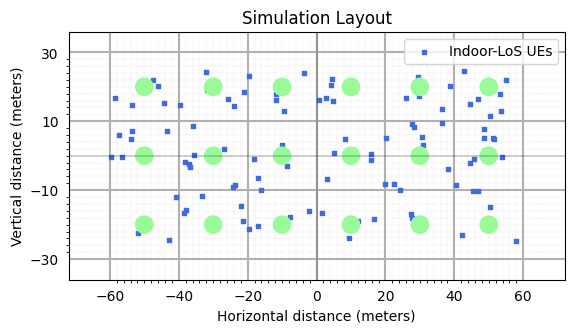

In [4]:
## Generate the Wireless Channel

# Antenna Array at UE side
# assuming antenna element type to be "OMNI"
# with 2 panel and 2 single polarized antenna element per panel.
ueAntArray = AntennaArrays(antennaType = "OMNI",  centerFrequency = carrierFrequency, arrayStructure  = np.array([1,1,2,2,1]))
ueAntArray()

# # Radiation Pattern of Rx antenna element
# ueAntArray.displayAntennaRadiationPattern()


# Antenna Array at BS side
# assuming antenna element type to be "3GPP_38.901", a parabolic antenna
# with 4 panel and 4 single polarized antenna element per panel.
bsAntArray = AntennaArrays(antennaType = "3GPP_38.901", centerFrequency = carrierFrequency, arrayStructure  = np.array([1,1,16,4,1]))
bsAntArray()

# # Radiation Pattern of Tx antenna element
# bsAntArray[0].displayAntennaRadiationPattern()

# Layout Parameters
isd                  = 20          # inter site distance
minDist              = 0          # min distance between each UE and BS
ueHt                 = 1.5         # UE height
bsHt                 = 5          # BS height
bslayoutType         = "Rectangular" # BS layout type
ueDropType           = "Rectangular" # UE drop type
htDist               = "equal"       # UE height distribution
ueDist               = "random"       # UE Distribution per site
nSectorsPerSite      = 1             # number of sectors per site
maxNumFloors         = 1             # Max number of floors in an indoor object
minNumFloors         = 1             # Min number of floors in an indoor object
heightOfRoom         = 5.1             # height of room or ceiling in meters
indoorUEfract        = 0.5           # Fraction of UEs located indoor
lengthOfIndoorObject = 3             # length of indoor object typically having rectangular geometry
widthOfIndoorObject  = 3             # width of indoor object
forceLOS             = True          # boolen flag if true forces every link to be in LOS state
# forceLOS             = False       # boolen flag if true forces every link to be in LOS state

# simulation layout object
simLayoutObj = SimulationLayout(numOfBS = numOfBSs,
                                numOfUE = nUEs,
                                heightOfBS = bsHt,
                                heightOfUE = ueHt,
                                ISD = isd,
                                layoutType = bslayoutType,
                                layoutWidth = 50,
                                layoutLength = 120,
                                ueDropMethod = ueDropType,
                                UEdistibution = ueDist,
                                UEheightDistribution = htDist,
                                numOfSectorsPerSite = nSectorsPerSite,
                                ueRoute = None)

simLayoutObj(terrain = propTerrain,
             carrierFreq = carrierFrequency,
             ueAntennaArray = ueAntArray,
             bsAntennaArray = bsAntArray,
             indoorUEfraction = indoorUEfract,
             heightOfRoom = heightOfRoom,
             lengthOfIndoorObject = lengthOfIndoorObject,
             widthOfIndoorObject = widthOfIndoorObject,
             forceLOS = forceLOS)

# displaying the topology of simulation layout
fig, ax = simLayoutObj.display2DTopology()
ax.set_xlabel("x-coordinates (m)")
ax.set_ylabel("y-coordinates (m)")
ax.set_title("Simulation Topology")
ax.axhline(y=-0.5*isd*numOfBSs[1], xmin=10/140, xmax=130/140, color="k")
ax.axhline(y= 0.5*isd*numOfBSs[1], xmin=10/140, xmax=130/140, color="k")
ax.axvline(x=-0.5*isd*numOfBSs[0], ymin=10/140, ymax=130/140, color="k")
ax.axvline(x= 0.5*isd*numOfBSs[0], ymin=10/140, ymax=130/140, color="k")

paramGen = simLayoutObj.getParameterGenerator()

# paramGen.displayClusters((0,0,0), rayIndex = 0)
channel = paramGen.getChannel()
Hf      = channel.ofdm(scs, Nfft)[0]

Nt        = bsAntArray.numAntennas # Number of BS Antennas
Ntx       = bsAntArray.arrayStructure[3]
Nty       = bsAntArray.arrayStructure[2]
Nr        = ueAntArray.numAntennas

## SRS Configurations

In [5]:
## SRS Configurations
purpose			    = "positioning"
nrofSRS_Ports		= 1
transmissionComb	= 4
nrofSymbols		    = 12
startPosition		= 2
repetitionFactor	= 1
nrOfCyclicShift		= 1
groupOrSequenceHopping	= "neither"
sequenceId		        = np.arange(nUEs)

systemFrameNumber	    = 0
resourceType		    = "periodic"
subcarrierSpacing 	    = scs

bSRS 			        = 0
cSRS 			        = 21
bHop 			        = 0

freqScalingFactor 	    = 1
startRBIndex 		    = 0
enableStartRBHopping 	= False
freqDomainShift 	    = 0
freqDomainPosition 	    = 0
srsPeriodicityInSlots 	= 1
srsOffsetInSlots 		= 0
betaSRS 		        = 1
resourceGridSizeinRBs 	= numRBs
Bandwidth               = resourceGridSizeinRBs*12*scs

## Slot by Slot Simulation

- Schedule a certain UEs for SRS transmission in each slot.
- Beamform the slot Grid.
- Pass the beamformed Grid through the wireless channel.
    - Consider inter-user interference.
- Extract the resource Grid.
- Estimate the channel between the scheduled users and each BS.
    - Estimate the channel using LS estimator.
    - Interpolate the channel for un-scheduled REs in the slot Grid.
- Estimate the time of arrival (ToA) for each UE-BS link.

In [6]:
print("***********  Transmission Grid Beamformed *********** ")
numRepetition    = 1
numSlotsPerFrame = np.int32(10*(15000/scs))
numUEsPerSlot    = transmissionComb
numSlots         = np.int32(np.ceil(nUEs*numRepetition/transmissionComb))
frameIndices     = np.int32(np.floor(np.arange(numUEsPerSlot*numRepetition)/transmissionComb)%numSlotsPerFrame)
slotIndices      = np.int32(np.floor(np.floor(np.arange(numUEsPerSlot*numRepetition)/transmissionComb)/numSlotsPerFrame))
combOffset       = np.int32(np.arange(numUEsPerSlot))

Lpath            = 4
doaEst           = np.zeros((nBSs, nUEs, 2, Lpath))
xoAEst           = np.zeros((nBSs, nUEs, 2))
# Create a ESPRIT DoA Object
espritDoa        = ESPRIT_DoA(Ntx, Nty, numRBs*12)

for ns in range(numSlots):
    print("*********** Simulating slot-["+str(ns)+"] *********** ")
    
    ## SRS Grid Generation

    srsGrid      = np.zeros((numUEsPerSlot, 14, numRBs*12), dtype=np.complex64)
    srsObject    = np.empty((numUEsPerSlot), dtype=object)

    for nue in range(numUEsPerSlot):
        srsObject[nue]   = ResourceMapperSRS(nrofSRS_Ports, transmissionComb, nrofSymbols, startPosition,
                                             repetitionFactor, nrOfCyclicShift, groupOrSequenceHopping, 
                                             sequenceId[nue], combOffset[nue], ns, frameIndices[nue], 
                                             resourceType, purpose, subcarrierSpacing)

        srsGrid[nue] = srsObject[nue](bSRS, cSRS, bHop, freqScalingFactor, startRBIndex, 
                                          enableStartRBHopping, freqDomainShift, freqDomainPosition, 
                                          srsPeriodicityInSlots, srsOffsetInSlots, betaSRS, 
                                          resourceGridSizeinRBs)[0,0,0]

    XGrid     = np.zeros((numUEsPerSlot, 14, Nfft), dtype=np.complex64)
    bwpOffset = np.random.randint(Nfft-resourceGridSizeinRBs*12)

#     print("***********  SRS Grid Generated *********** ")
    ## Load the resource grid to Transmission Grid
    XGrid[...,bwpOffset:(bwpOffset+resourceGridSizeinRBs*12)] = srsGrid

#     print("***********  Transmission Grid Generated *********** ")

    del srsGrid

    ## Beamforming
    # Beamforming angles
    # Inter-element spacing in vertical and horizontal
    Pt_dBm= 23
    Pt    = 10**(0.1*(Pt_dBm-30))
    lamda = 3*10**8/carrierFrequency
    d     = 0.5/lamda
    theta = 0
    # Wt    = np.sqrt(Pt/Nt)*np.exp(1j*2*np.pi*d*np.cos(theta)/(lamda*Nt)*np.arange(0,Nt))
    # Xf    = Wt.reshape(-1,1,1)*XGrid1
    Xf    = np.sqrt(transmissionComb*Pt/Nr)*XGrid[..., np.newaxis].repeat(Nr, axis = -1)
    del XGrid
    
    ueIndices     = np.arange(ns*numUEsPerSlot, (ns+1)*numUEsPerSlot)
    ## Pass through channel
    Yf = (Hf[:,:,ueIndices].transpose(1,2,0,3,5,4)@Xf[np.newaxis,...,np.newaxis]).sum(1)

#     print("***********  ["+str(ns)+"]-Passed Through Channel *********** ")

    ## Add Noise
    BoltzmanConst = 1.380649*(10**(-23))
    temperature   = 300
    noisePower    = BoltzmanConst*temperature*Bandwidth
    noisePower    = BoltzmanConst*temperature*scs
    kppm          = 0
    fCFO          = kppm*(np.random.rand()-0.5)*carrierFrequency*(10**(-6)); # fCFO = CFO*subcarrierSpacing
    CFO           = (fCFO/scs)/Nfft
    ##Yf            = AddNoise(True)(Y, noisePower, CFO)

    # Yf            = AddNoise(False)(Y, noisePower, 0)    #Added
    Yf            = np.complex64(Yf + np.sqrt(0.5*noisePower)*(np.random.standard_normal(Yf.shape) + 1j*np.random.standard_normal(Yf.shape)))

#     print("***********  ["+str(ns)+"]-Noise Added *********** ")

    ## Extract Resource Grid
    rxGrid = Yf[...,bwpOffset:(bwpOffset+resourceGridSizeinRBs*12),:,0].transpose(0,3,1,2)

#     print("***********  ["+str(ns)+"]-Resource Grid Extracted *********** ")

    ## Channel Estimation and Interpolation
    Hfest = np.zeros((nBSs, numUEsPerSlot, Nt, 14, rxGrid.shape[-1]), dtype = np.complex64)
    chEST = ChannelEstimationSRS()
    chGrid = rxGrid.reshape(nBSs*Nt,14,-1)[:,np.newaxis,np.newaxis,np.newaxis]

    interpolatorType = "Cubic" # "Spline", "Linear", "Cubic"

    for nue in range(numUEsPerSlot):
#         print("UE-Index: "+str(ueIndices[nue])+" | slot-Index: "+str(ns))

        Hfest[:,nue] = chEST(chGrid, srsObject[nue], interpolatorType)[:,0,0,0].reshape(nBSs,Nt,14,-1)

    Hest = Hfest.mean(-2)/14

#     print("***********  ["+str(ns)+"]-Channel Estimated *********** ")

    ## DoA Estimation
    for nbs in range(nBSs):
        for nue in range(numUEsPerSlot):
#             print("(nbs, nue): ("+str(nbs)+", "+str(ueIndices[nue])+")")
            # Ntx, Nty, dtx, dty will be taken from antenna arrays propoerties
            # Hk is estimated at the receiver.
            # However, for perfect CSI, it can be directly taken from channel.OFDM.

            doaEst[nbs, ueIndices[nue]] = espritDoa(Hest[nbs, nue], Lpath, 0.5, 0.5)    # Return 2 x 5 DoA matrix
            # row-0 is azimuth angles for each path
            # row-1 is elevation angles for each path

    print("***********  ["+str(ns)+"]-AoA Estimated *********** ")    
# xoAEst        = doaEst[...,0]
# xoAEst[...,0] = np.where(xoAEst[...,0] > 180, xoAEst[...,0] - 360, xoAEst[...,0])
# xoAEst[...,1] = np.where(xoAEst[...,1] < -270, xoAEst[...,1] + 360, xoAEst[...,1])


***********  Transmission Grid Beamformed *********** 
*********** Simulating slot-[0] *********** 
***********  [0]-AoA Estimated *********** 
*********** Simulating slot-[1] *********** 


/home/tenet/Startup/Packages/5G_Toolkit/version15/Tutorials/Simulations/Tutorial-23[Angle_based_Positioning]/../../../toolkit5G/Positioning/Angle_Estimation/methods/espritDoA.py:103: RuntimeWarning: invalid value encountered in arcsin
  theta    = np.pi - np.arcsin(np.sqrt(np.abs(kx*ui)**2 + np.abs(ky*vi)**2)).reshape(1,-1)


***********  [1]-AoA Estimated *********** 
*********** Simulating slot-[2] *********** 
***********  [2]-AoA Estimated *********** 
*********** Simulating slot-[3] *********** 
***********  [3]-AoA Estimated *********** 
*********** Simulating slot-[4] *********** 
***********  [4]-AoA Estimated *********** 
*********** Simulating slot-[5] *********** 
***********  [5]-AoA Estimated *********** 
*********** Simulating slot-[6] *********** 
***********  [6]-AoA Estimated *********** 
*********** Simulating slot-[7] *********** 
***********  [7]-AoA Estimated *********** 
*********** Simulating slot-[8] *********** 
***********  [8]-AoA Estimated *********** 
*********** Simulating slot-[9] *********** 
***********  [9]-AoA Estimated *********** 
*********** Simulating slot-[10] *********** 
***********  [10]-AoA Estimated *********** 
*********** Simulating slot-[11] *********** 
***********  [11]-AoA Estimated *********** 
*********** Simulating slot-[12] *********** 
***********  [12

## Position Estimation: Based on UL-ToA

In [7]:
xoA       = np.stack([paramGen.phiAoD_LoS[0], paramGen.thetaAoD_LoS[0]], axis = -1)
xoAEst    = doaEst[...,0]
txPosition= simLayoutObj.BSLocations

k         = 3  # Select k-best measurements
error     = np.abs(xoAEst - xoA).sum(-1) # Compute the DoA error in each measurement
bsIndices = (np.argsort(error,axis=0)[0:k]).T

# Position Estimation Object: 
    # Positioning based on: DoA
    # Optimization Method: Gradient Descent
posEstimator = LeastSquareDoA()

rxPositionEstimate    = np.zeros((nUEs, 3))
std     = np.zeros((nUEs, 2))

for nue in range(nUEs):
    rxPositionEstimate[nue], std[nue] = posEstimator(txPosition[bsIndices[nue]], xoAEst[bsIndices[nue],nue]*np.pi/180)
#     print("nue: "+str(nue)+" | Rx Location Estimate: "+str(rxPositionEstimate[nue]))

## Visualization: Direction of Arrival Locus Lines

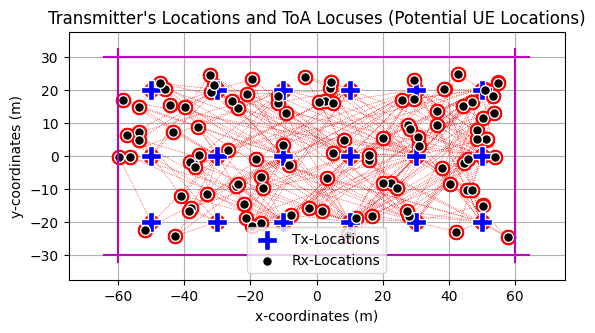

In [8]:
#################################################################
rxPosition  = simLayoutObj.UELocations
txPosition  = simLayoutObj.BSLocations
rangeEst_2D = np.linalg.norm(rxPosition[np.newaxis,:,:] - txPosition[:,np.newaxis,:], axis=-1)

fig, ax = plt.subplots()
colors  = ["k","m","r","b","g","y","crimson"]

linestyle_tuple = ['solid', 'dotted', 'dashed', 'dashdot', 
                   (0, (5, 10)),                # 'loosely dashed'
                   (0, (1, 10)),                # 'loosely dotted'
                   (5, (10, 3)),                # 'long dash with offset'
                   (0, (5, 1)),                 # 'densely dashed'
                   (0, (3, 10, 1, 10)),         # 'loosely dashdotted'
                   (0, (3, 5, 1, 5)),           # 'dashdotted'
                   (0, (3, 1, 1, 1)),           # 'densely dashdotted'
                   (0, (3, 5, 1, 5, 1, 5)),     # 'dashdotdotted'
                   (0, (3, 10, 1, 10, 1, 10)),  # 'loosely dashdotdotted'
                   (0, (3, 1, 1, 1, 1, 1))]     # 'densely dashdotdotted'

for nbs in range(k):
    for nue in range(nUEs):
            ax.plot([txPosition[bsIndices[nue, nbs],0], 
                     txPosition[bsIndices[nue, nbs],0] + rangeEst_2D[bsIndices[nue, nbs], nue]*np.cos(xoAEst[bsIndices[nue, nbs], nue, 0]*np.pi/180)*np.sin(xoAEst[bsIndices[nue, nbs], nue, 1]*np.pi/180)], 
                    [txPosition[bsIndices[nue, nbs],1], 
                     txPosition[bsIndices[nue, nbs],1] + rangeEst_2D[bsIndices[nue, nbs], nue]*np.sin(xoAEst[bsIndices[nue, nbs], nue, 0]*np.pi/180)*np.sin(xoAEst[bsIndices[nue, nbs], nue, 1]*np.pi/180)], 'ro:', lw = 0.5, ms = 10)

ax.scatter(txPosition[:,0], txPosition[:,1], marker="P", color="b", edgecolors='white', s = 200, label="Tx-Locations", zorder = 2)
ax.scatter(rxPositionEstimate[:,0], rxPositionEstimate[:,1], marker="o", color="k", edgecolors='white', s = 50, label="Rx-Locations", zorder = 2)
ax.legend()
ax.set_xlabel("x-coordinates (m)")
ax.set_ylabel("y-coordinates (m)")
ax.set_xlim([-75, 75])
ax.set_ylim([-37.5, 37.5])
ax.axhline(y=-0.5*isd*numOfBSs[1], xmin=10/140, xmax=130/140, color="m")
ax.axhline(y= 0.5*isd*numOfBSs[1], xmin=10/140, xmax=130/140, color="m")
ax.axvline(x=-0.5*isd*numOfBSs[0], ymin=10/140, ymax=130/140, color="m")
ax.axvline(x= 0.5*isd*numOfBSs[0], ymin=10/140, ymax=130/140, color="m")
ax.set_title("Transmitter's Locations and ToA Locuses (Potential UE Locations)")
ax.grid(True)
ax.set_aspect(True)
plt.show()
#________________________________________________________________

## Visualization of Estimated Position and its accuracy

``Note``: Please use the intractive matplotlib **%matplotlib widget** to see this graph.

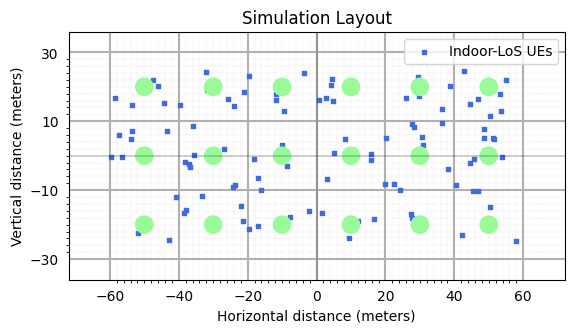

In [9]:
## PSS Detection Plot
#################################################################
rxPosition  = simLayoutObj.UELocations
txPosition  = simLayoutObj.BSLocations
# rangeEst_2D = np.sqrt(np.abs((ToAe*(3*10**8))**2 - (rxPosition[:,2].reshape(1,-1)-txPosition[:,2].reshape(-1,1))**2))

# fig, ax = plt.subplots()
fig, ax = simLayoutObj.display2DTopology(isEqualAspectRatio = True)
colors  = ["k","m","r","b","g","y","crimson"]

linestyle_tuple = ['solid', 'dotted', 'dashed', 'dashdot', 
                   (0, (5, 10)),                # 'loosely dashed'
                   (0, (1, 10)),                # 'loosely dotted'
                   (5, (10, 3)),                # 'long dash with offset'
                   (0, (5, 1)),                 # 'densely dashed'
                   (0, (3, 10, 1, 10)),         # 'loosely dashdotted'
                   (0, (3, 5, 1, 5)),           # 'dashdotted'
                   (0, (3, 1, 1, 1)),           # 'densely dashdotted'
                   (0, (3, 5, 1, 5, 1, 5)),     # 'dashdotdotted'
                   (0, (3, 10, 1, 10, 1, 10)),  # 'loosely dashdotdotted'
                   (0, (3, 1, 1, 1, 1, 1))]     # 'densely dashdotdotted'

# for nbs in range(k):
#     for nue in range(nUEs):
#             circle1 = plt.Circle((txPosition[kBestIndices[nue, nbs], 0], txPosition[kBestIndices[nue, nbs], 1]), rangeEst_2D[kBestIndices[nue, nbs], nue], 
#                                  color = colors[nue%7], lw = 0.35, ls = linestyle_tuple[nue%7], fill = False, zorder = 0)
#             ax.add_artist(circle1)

ax.scatter(txPosition[:,0], txPosition[:,1], marker="P", color="b", edgecolors='white', 
           s = 125, label="Tx-Locations", zorder = 3)
ax.scatter(rxPositionEstimate[:,0], rxPositionEstimate[:,1], marker="o", color="g", 
           s = 75, label="Estimated Rx-Locations", zorder = 1)
ax.scatter(rxPosition[:,0], rxPosition[:,1], marker=".", color="r", edgecolors='white', 
           s = 100, label="True Rx-Locations", zorder = 5)
ax.legend()
ax.set_title("Transmitter's Locations and Estimation Accuracy (True UE Location vs Estimated UE Locations)")
# ax.set_xlim([-200, 200])
# ax.set_ylim([-200, 200])
ax.grid(True)

## Performance Analysis of Positioning Error for UL-AoA method

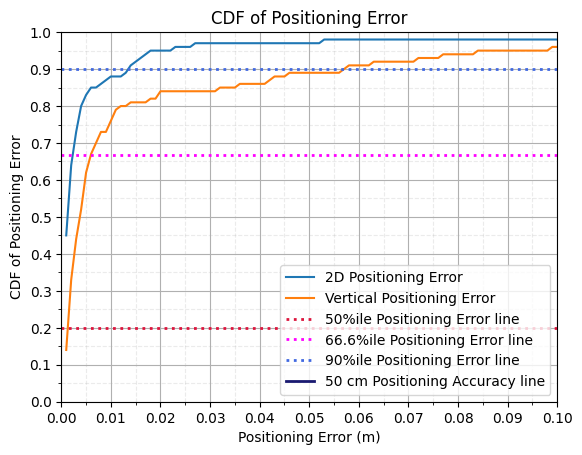

In [10]:
nbins = nUEs
xlimit = 0.1
ylimit = 1
posError3D = np.linalg.norm(rxPositionEstimate-rxPosition[:], axis=1)
posError3D = np.where(np.isnan(posError3D), 0, posError3D)
posError2D = np.linalg.norm(rxPositionEstimate[:, 0:2]-rxPosition[:, 0:2], axis=1)

# Horizontal Error
count, bins_count = np.histogram(posError2D, bins = nbins, range = [0, xlimit])
pdf = count/nUEs
cdf = np.cumsum(pdf)

fig, ax = plt.subplots()
ax.plot(bins_count[1:], cdf, label = "2D Positioning Error")


# Vertical Error
count, bins_count = np.histogram(posError3D, bins = nbins, range = [0, xlimit])
pdf = count/nUEs
cdf = np.cumsum(pdf)
ax.plot(bins_count[1:], cdf, label = "Vertical Positioning Error")

ax.set_xticks(np.linspace(0, xlimit, 11))
ax.set_xticks(np.linspace(0, xlimit, 21), minor=True)
ax.set_yticks(np.linspace(0, ylimit, 11))
ax.set_yticks(np.linspace(0, ylimit, 21), minor=True)
ax.set_xlabel("Positioning Error (m)")
ax.set_ylabel("CDF of Positioning Error")
ax.set_title("CDF of Positioning Error")
ax.axhline(y = 0.2, lw = 2, alpha = 1, linestyle = ':', color = "crimson", label = "50%ile Positioning Error line")
ax.axhline(y = 2/3, lw = 2, alpha = 1, linestyle = ':', color = "magenta", label = "66.6%ile Positioning Error line")
ax.axhline(y = 0.9, lw = 2, alpha = 1, linestyle = ':', color = "royalblue", label = "90%ile Positioning Error line")
ax.axvline(x = 0.2, lw = 2, alpha = 1, linestyle = '-', color = "midnightblue", label = "50 cm Positioning Accuracy line")

# Specify different settings for major and minor grids
ax.grid(which = 'minor', alpha = 0.25, linestyle = '--')
ax.grid(which = 'major', alpha = 1)

ax.set_xlim([0,xlimit])
ax.set_ylim([0,ylimit])
ax.legend()
plt.show()

# # Code to save the Database
# idx  = 0
# flag = True
# while(flag):
#     print("flag: "+str(idx)+" | i="+str(idx))
#     filename = "Databases/ULAoA-"+str([idx])+".npz"
#     if(os.path.exists(filename)):
#         idx  = idx + 1
#     else:
#         np.savez(filename, posError3D = posError3D, posError2D = posError2D, 
#                  rxPositionEstimate = rxPositionEstimate, rxPosition = rxPosition, 
#                  xoA = xoA, xoAEst = xoAEst, txPosition = txPosition, scs = scs,
#                  carrierFrequency = carrierFrequency,  Nfft = Nfft, nBSs = nBSs, 
#                  nUEs = nUEs, numRBs = numRBs, propTerrain = propTerrain, 
#                  bsArrayStructure  = bsAntArray.arrayStructure, 
#                  ueArrayStructure  = ueAntArray.arrayStructure)
#         flag = False

## Performance Analysis for UL-AoA method: 1300 UEs

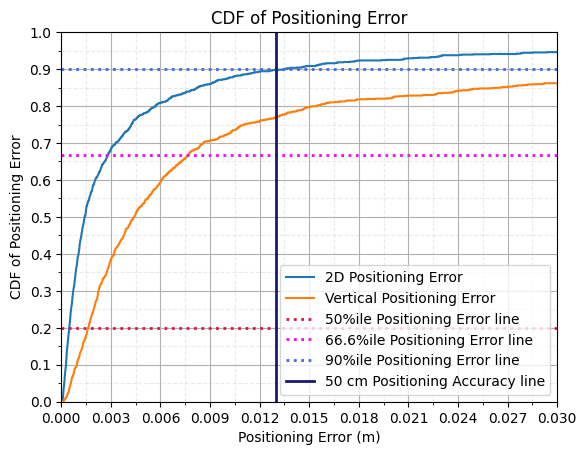

In [15]:
filename = "Databases/ULAoA-"+str([0])+".npz"
ds       = np.load(filename)

posError3D = ds["posError3D"]
posError2D = ds["posError2D"]

for i in range(1,7):
    
    filename = "Databases/ULAoA-"+str([i])+".npz"
    ds         = np.load(filename)
    
    posError3D = np.concatenate([posError3D, ds["posError3D"]])
    posError2D = np.concatenate([posError2D, ds["posError2D"]])

nbins = posError2D.size
xlimit = 0.03
ylimit = 1

# Horizontal Error
count, bins_count = np.histogram(posError2D, bins = nbins, range = [0, xlimit])
pdf = count/nbins
cdf = np.cumsum(pdf)

fig, ax = plt.subplots()
ax.plot(bins_count[1:], cdf, label = "2D Positioning Error")

# Vertical Error
count, bins_count = np.histogram(posError3D, bins = nbins, range = [0, xlimit])
pdf = count/nbins
cdf = np.cumsum(pdf)
ax.plot(bins_count[1:], cdf, label = "Vertical Positioning Error")

ax.set_xticks(np.linspace(0, xlimit, 11))
ax.set_xticks(np.linspace(0, xlimit, 21), minor=True)
ax.set_yticks(np.linspace(0, ylimit, 11))
ax.set_yticks(np.linspace(0, ylimit, 21), minor=True)
ax.set_xlabel("Positioning Error (m)")
ax.set_ylabel("CDF of Positioning Error")
ax.set_title("CDF of Positioning Error")
ax.axhline(y = 0.2, lw = 2, alpha = 1, linestyle = ':', color = "crimson", label = "50%ile Positioning Error line")
ax.axhline(y = 2/3, lw = 2, alpha = 1, linestyle = ':', color = "magenta", label = "66.6%ile Positioning Error line")
ax.axhline(y = 0.9, lw = 2, alpha = 1, linestyle = ':', color = "royalblue", label = "90%ile Positioning Error line")
ax.axvline(x = 0.013, lw = 2, alpha = 1, linestyle = '-', color = "midnightblue", label = "50 cm Positioning Accuracy line")

# Specify different settings for major and minor grids
ax.grid(which = 'minor', alpha = 0.25, linestyle = '--')
ax.grid(which = 'major', alpha = 1)

ax.set_xlim([0,xlimit])
ax.set_ylim([0,ylimit])
ax.legend()
plt.show()